# Tools to Help Plan NIRSpec IFU Observations

This notebook demonstrates how to use some tools in ``breads`` to help plan JWST NIRSpec IFU observations. 

In [1]:
%pylab inline
import astropy.units as u
import breads.jwst_tools.planning as jw_planning
import breads.utils

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Visualizing JWST IFU FOV and diffraction spikes. 

This example is based on the program 1414 obs of HD 19467 B.

Use `visualize_nrs_fov` to depict where a companion will fall relative to NIRSpec IFU FOV and PSF diffraction features, and also the potential effects of saturated pixels around a bright PSF core. (Note, this quick tool does NOT assess saturation, instead use the ETC for that. This just flags which slices are most likely to have an issue with that.)

You need to tell this function the relative position of the companion, and a desired V3PA position angle for JWST. 

Offset star by 0.000, 0.000 arcsec in (V2, V3) frame.
Aperture NRS_FULL_IFU has V3IdlYAngle =  138.972
For V3PA = 211.0, NIRSpec NRS_FULL_IFU aperture PA (including pipeline IFUAlign rotation) is 260.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 23.97 from the star
   Therefore star is oriented to local aperture angle 203.97 from the companion
    (for stpsf sim use offset -0.650, -1.462 arcsec) 
Caution: NRS_IFU_SLICE00 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE01 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE03 contains the PSF core, and may have saturated pixels and increased noise 


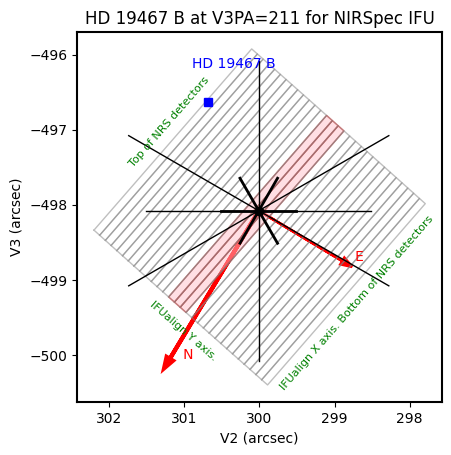

In [2]:
jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True)


The plot is oriented and labeled in the overall coordinate system of JWST's focal plane, the so-called V frame. See [this JDox page](https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-telescope/jwst-focal-plane#gsc.tab=0) for description of that frame.  The NIRSpec IFU FOV is rotated about 140 deg relative to that frame. 

The plot also indicates which sides of the FOV correspond to the X and Y axes in pipeline-processed s3d datacubes *in the IFUAlign* frame. See pipeline cube build documentation for details. Note, the IFUAlign outputs have a semi-arbitrary 90 degree rotation in the cubes; the "X" axis in IFUAlign cubes actually corresponds to the "Y" axis in NIRSpec detector pixels. This can be a subtle annoyance. 

That PA works pretty well to have the companion away from the spikes, but the companion ends up too close to the edge. 

## Offset pointings with the NIRSpec IFU


Let's recenter the IFU to point at the companion, using the `center_on` keyword.

Offset star by -0.676, -1.450 arcsec in (V2, V3) frame.
Aperture NRS_FULL_IFU has V3IdlYAngle =  138.972
For V3PA = 211.0, NIRSpec NRS_FULL_IFU aperture PA (including pipeline IFUAlign rotation) is 260.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 23.97 from the star
   Therefore star is oriented to local aperture angle 203.97 from the companion
    (for stpsf sim use offset -0.650, -1.462 arcsec) 
Caution: NRS_IFU_SLICE24 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE26 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE28 contains the PSF core, and may have saturated pixels and increased noise 


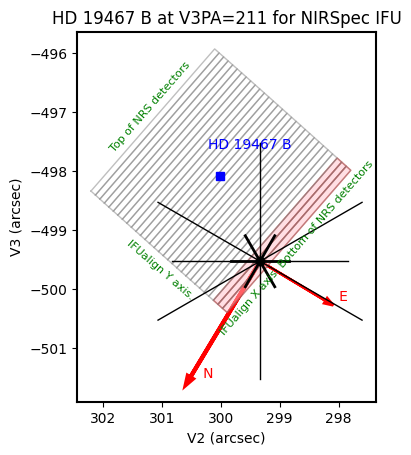

In [3]:
jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True,
                             center_on='comp')


If we want to do that, how can we most tell JWST to do that? Two options:

 - Set a relative offset special requirement on the observation. This is **tricky to get right** because (a) That special requirement offset is specified in the *local aperture coordinate system* of the IFU, which is rotated ~140 degrees relative to the V frame for NIRSpec IFU, so you need to do a coordinate rotation. And furthermore, (b) That offset then depends on the position angle of the observatory, so if you have a PA range or if you have two rolls for ADI, you need to compute the offset SRs depending on the specific PAs used.  
 - Alternatively, just tell JWST to point the IFU at the absolute RA and Dec which correspond to the expected position of the companion. (We usually think about companion astrometry as relative to the star, but we can just convert to absolute astrometry in the ICRS frame.)

Both approaches have pros and cons, so pick whichever you prefer for your science program.

## Computing absolute coordinates for offset pointings

``breads`` has a function to compute the absolute coordinates of a companion for you. This is ``companion_relative_to_absolute_position``.  It returns an ``astropy.coords.SkyCoord`` object with the ICRS coordinates of the companion.  It also helpfully prints out the information you would need to enter into APT. Make sure to get the proper motion and epoch correct!!

In [4]:
breads.utils.companion_relative_to_absolute_position('HD 19467', 
                                                     comp_name = 'HD 19467 B', 
                                                     comp_sep = 1.6*u.arcsec,
                                                     comp_pa = 236*u.deg, 
                                                     obs_date = '2023-01-20')

**HOST STAR:**
Retrieving SIMBAD coordinates for HD 19467
Coordinates at J2000:  03h07m18.57505144s -13d45m42.41798215s
Coordinates at 2023-01-20:  03h07m18.56129591s -13d45m48.42612868s
Proper motion  pm_ra_cosdec: -8.694 mas / yr	pm_dec: -260.642 mas / yr
Parallax : 31.219 mas

**COMPANION:**
HD 19467 B has r=1.6 arcsec, pa=236.0 deg, which is (dDec,dR.A.) = -0.895 arcsec, -1.326 arcsec
HD 19467 B ICRS coords at 2023-01-20: 03h07m18.4702509s -13d45m49.32083628s

        Crosscheck PA: 236.000 deg  should equal 236.0 deg
        Crosscheck sep: 1.600000 arcsec  should equal 1.6 arcsec 
        if the above are not equal then something went wrong in this calculation. 

**COMPANION ABSOLUTE POINTING INFO FOR APT:**
	Name:			HD 19467 B
	ICRS coordinates:	03 07 18.4702509 -13 45 49.32083628
	Epoch:			2023.05
	Proper Motion:		RA: -8.694 mas / yr	Dec: -260.642 mas / yr
	Annual Parallax:	0.0312 arcsec


<SkyCoord (ICRS): (ra, dec) in deg
    (46.82695938, -13.76370023)>

## And similarly for MIRI MRS too

There is now also a similar function for this. Use ``visualize_miri_mrs_fov``.  This has a ``channel`` parameter so you can select which of the 4 channels times 3 sub-bands should be shown.

Offset star by 0.000, 0.000 arcsec in (V2, V3) frame.
Aperture MIRIFU_CHANNEL2A has V3IdlYAngle =  0.000
For V3PA = 211.0, MIRI MIRIFU_CHANNEL2A aperture PA (including pipeline IFUAlign rotation) is 211.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 335.00 from the star
   Therefore star is oriented to local aperture angle 155.00 from the companion
    (for stpsf sim use offset 0.676, -1.450 arcsec) 
Caution: MIRIFU_2ASLICE09 contains the PSF core, and may have saturated pixels and increased noise 


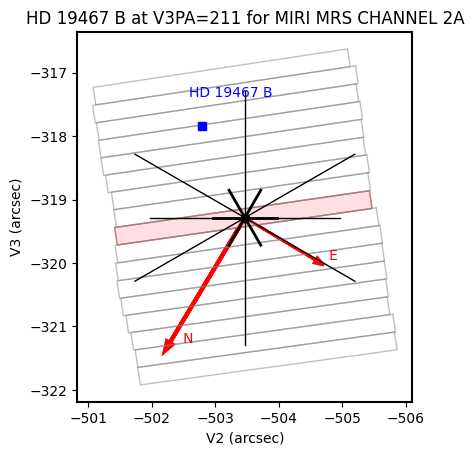

In [5]:
jw_planning.visualize_miri_mrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True,  psf_core_check_radius=0.7)


Offset star by 0.000, 0.000 arcsec in (V2, V3) frame.
Aperture MIRIFU_CHANNEL1A has V3IdlYAngle =  0.000
For V3PA = 211.0, MIRI MIRIFU_CHANNEL1A aperture PA (including pipeline IFUAlign rotation) is 211.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 335.00 from the star
   Therefore star is oriented to local aperture angle 155.00 from the companion
    (for stpsf sim use offset 0.676, -1.450 arcsec) 
Caution: MIRIFU_1ASLICE11 contains the PSF core, and may have saturated pixels and increased noise 


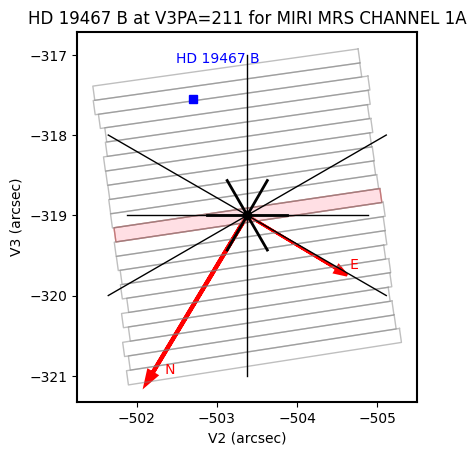

In [8]:
jw_planning.visualize_miri_mrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                                   miri_channel='1A',
                              v3pa=211, verbose=True)
